# TODO
 - keep the confusion matrix estimation same - across all trials?
 - double check that params are getting properly propagated for the Agent and environment
 - ~~grid search for parameters~~
 - figure out parameters in surrogate rewards
 - ~~make rewards non binary in environment and surrogate rewards~~
 - ~~add deceay from papers, log and other~~
 - initiate q-table at `-1`?
 - run experiment with different `correct_action`
 - should we be setting up the glove for `very distinguishable` levels? Shouldn't we set it up with `barely distinguishable` levels, as this is where the perturbed rewards come on - they'd help us get through the noise and find the correct level.

# Scripts

In [1]:
import numpy as np
import collections
import pandas as pd
import argparse
import time
import numpy as np

In [2]:
import noise_estimator

In [3]:
# from ucbq_agent import UCBQAgent
from ucbq_agent_stateless import UCBQAgent
# from ucbq_environment import ModifiedRandomEnvironment
from ucbq_environment_stateless import ModifiedRandomEnvironment

# Params

In [4]:
max_steps = 120
num_episodes = 100

In [5]:
num_actions = 7
# start_state = 1
start_action = 0

In [6]:
# zero indexed
correct_action = 6

In [7]:
# def default_params():
#     """ These are the default parameters used int eh framework. """
#     return {
#             # # Runner parameters
#             # 'max_episodes': int(1E6),         # experiment stops after this many episodes
#             # 'max_steps': int(1E9),            # experiment stops after this many steps
#             # 'multi_runner': False,            # uses multiple runners if True
#             # Optimization parameters
#             'alpha': 0.5,                       # learning rate of optimizer
#             'alpha_decay': 40,
#             'alpha_min': 0.001,
#             # Exploration parameters
#             'epsilon': 1,               # annealing starts at this epsilon
#             'epsilon_decay': 0.5,
#             'epsilon_min': 0.01,    
#             'gamma': 0.95,                    # discount factor gamma
#             'plots': False,
#            }

# Scripts

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import utils

In [9]:
def get_mean_across_episodes(arr):
    min_cols = np.amin([len(row) for row in arr])
    truncated_arr = [ x[:min_cols] for x in arr ]
    res = np.array(truncated_arr)
    mean = res.mean(axis=0)

    return mean    

def get_cumsum_rewards(rewards):
    cumulative_sum_rewards = np.cumsum(rewards)
    time_steps = np.arange(1, len(rewards) + 1)
    mean_rewards = cumulative_sum_rewards / time_steps
    return mean_rewards

In [10]:
from modified_pendulum_processor import ModifiedPendulumProcessor

In [11]:
def runner(adjust_rewards=None, 
           agent=None,
           env=None,
           params={}):

    agent = agent if agent else UCBQAgent()
    env = env if env else ModifiedRandomEnvironment()

    episode_rewards = 0
    rewards = []
    q_values_for_chart = []
    
    t = 0
    action = start_action
    state = 0
    plots = params.get('plots', True)
    noise = params.get('noise', False)
    surrogate = params.get('surrogate', False)
    reward_processor = None

    # surrogate can only be with noise=True for now
    if surrogate:
        noise = True
    
    if noise: 
        #TODO: should we keep/carry over the estimated confusion matrix across all episodes?
        reward_processor = ModifiedPendulumProcessor(surrogate=surrogate)

    while True:
        if t == max_steps - 1:
            break

        action = agent.choose_action(state) 
        reward, next_state, done = env.step(action)        
        
        if done:
            break     

        rewards.append(reward)

        if noise or surrogate:
            observation, reward, done, info = reward_processor.process_step(state, reward, None, None, action)
        
        agent.learn(state, action, reward, next_state)
        episode_rewards += reward
        t += 1

        if plots:
            if t % 10 == 0:
                sum_q_values_across_states = np.around(np.sum(agent.Q, axis=0), decimals=4)
                q_values_for_chart.append(sum_q_values_across_states)
      
                
    episode_length = t + 1
    selected_action = action 
    
    if t == max_steps - 1:
        # If we reached the end of the episode
        # select the action with the highest Q-values as the correct one
        sum_q_values_across_states = np.sum(agent.Q, axis=0)
        selected_action = np.argmax(sum_q_values_across_states)

    return q_values_for_chart, rewards, episode_length, selected_action, reward_processor

In [12]:
def qLearningExperiment(learner=None, params={}):
    plots = params.get('plots', True)

    q_values_all_experiments = []
    rewards_all_experiments = []
    episode_lengths = []
    selected_actions = []

    for i in tqdm(range(num_episodes)):
        # TODO: .reset() instead of re-creating?
        agent = UCBQAgent(params=params) if learner is None else learner
        env = ModifiedRandomEnvironment(correct_action=correct_action)
        q_values_for_chart, rewards, episode_length, selected_action, reward_processor = runner(env=env, agent=agent, params=params)
        selected_actions.append(selected_action)
        episode_lengths.append(episode_length)
                
        rewards_all_experiments.append(rewards)
        q_values_all_experiments.append(q_values_for_chart)

    correct_count = selected_actions.count(correct_action)
    accuracy = (correct_count / len(selected_actions)) * 100
    
    return q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, reward_processor


In [13]:
def plot_mean_q_values(params={}):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, last_reward_processor = qLearningExperiment(params=params)
    print(f'Accuracy: {accuracy}')    
    print(f'Mean episode length: {np.mean(episode_lengths)}')

    all_mean_rewards = [ get_cumsum_rewards(rewards) for rewards in rewards_all_experiments ]

    all_mean_rewards = pd.DataFrame(all_mean_rewards) # rewards have different lengths
    # because they terminate earlier sometimes
    mean_matrix = np.mean(all_mean_rewards, axis=0)
    mean_rewards_across_episodes = pd.DataFrame(mean_matrix)

    mean_matrix = get_mean_across_episodes(q_values_all_experiments)
    mean_q_values_across_episodes = pd.DataFrame(mean_matrix)
    if params.get('noise', False): 
        print('Last reward processor:')
        last_reward_processor.print()

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    mean_rewards_across_episodes.plot(ax=axes[0, 0], title='Mean reward for this step across all episodes')
    mean_q_values_across_episodes.plot(ax=axes[0, 1], title='Mean Q-values accross all episodes')
    pd.DataFrame(episode_lengths).plot(ax=axes[1, 0], title='Episode lengths', marker='*')
    pd.DataFrame(selected_actions).plot(ax=axes[1, 1], title='Guessed correct action per episode', marker='*')
    plt.tight_layout()
    plt.show()

# Real rewards UCB Q-learning

In [14]:
rewards_all_experiments = []

qs, rewards, _, _, _ = runner()
rewards_all_experiments.append(rewards)

In [15]:
agent = UCBQAgent()

runner(agent=agent)
utils.print_agent_stats(agent)

Q-table:
[[-7 -6 -5 -5 -5 -5  0]]
Number of times action was taken:
[[ 3.  2.  3.  4.  3.  2. 39.]]
Total timesteps:
50


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 866.57it/s]

Accuracy: 100.0
Mean episode length: 50.0


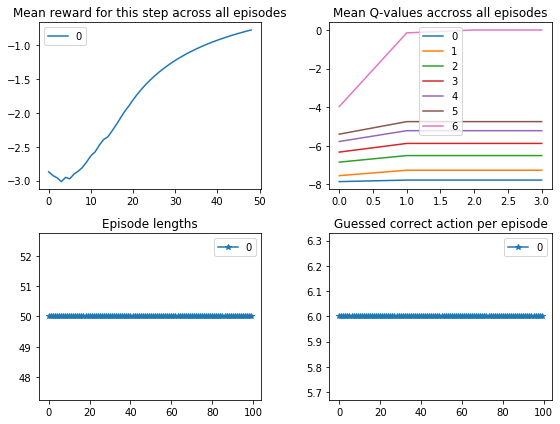

In [16]:
# The Q-value shape make sense - we're trying higher numbers later
# so they converge to -1 slower than e.g. action 0 or 1
plot_mean_q_values()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [17]:
# Confusion matrix used as noise
noise_estimator.initialize_cmat("anti_iden", num_actions, 0.2)

(array([[0.8, 0. , 0. , 0. , 0. , 0. , 0.2],
        [0. , 0.8, 0. , 0. , 0. , 0.2, 0. ],
        [0. , 0. , 0.8, 0. , 0.2, 0. , 0. ],
        [0. , 0. , 0. , 1. , 0. , 0. , 0. ],
        [0. , 0. , 0.2, 0. , 0.8, 0. , 0. ],
        [0. , 0.2, 0. , 0. , 0. , 0.8, 0. ],
        [0.2, 0. , 0. , 0. , 0. , 0. , 0.8]]),
 1)

100%|██████████| 100/100 [00:00<00:00, 525.14it/s]


Accuracy: 92.0
Mean episode length: 68.67
Last reward processor:
Original noise/confusion matrix:
[[0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.8 0.  0.  0.  0.2 0. ]
 [0.  0.  0.8 0.  0.2 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.8 0.  0. ]
 [0.  0.2 0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.  0.  0.  0.8]]
Reward sets:
{(0, 3): [-3], (0, 2): [-4, -2, -4], (0, 0): [0, -6, 0, -6, -6], (0, 5): [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -5], (0, 4): [-2, -4], (0, 1): [-5], (0, 6): [0, 0, 0, 0, 0, 0, -6, 0, -6, 0, 0, 0, -6, 0, 0, 0, -6, 0, 0, 0, 0, 0, 0, -6, 0, 0, -6, -6, 0, 0, -6, 0, 0, 0, 0, 0, 0, 0, 0, 0, -6, 0]}
Reward set counts:
Key (0, 3): 1 items
Key (0, 2): 3 items
Key (0, 0): 5 items
Key (0, 5): 12 items
Key (0, 4): 2 items
Key (0, 1): 1 items
Key (0, 6): 42 items
Estimated confusion matrix:
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


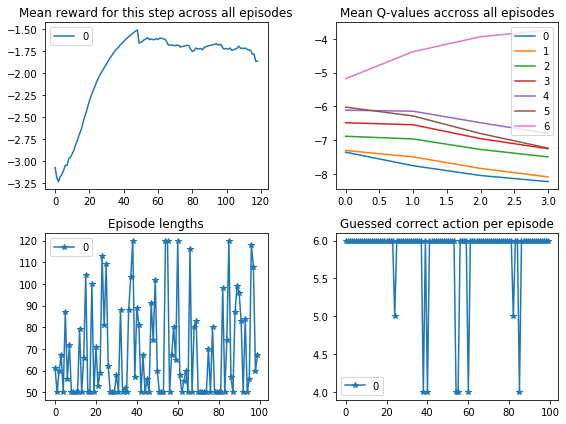

In [18]:
plot_mean_q_values(params={'noise': True})

# Surrogate rewards

100%|██████████| 100/100 [00:00<00:00, 127.22it/s]


Accuracy: 82.0
Mean episode length: 64.41
Last reward processor:
Original noise/confusion matrix:
[[0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.8 0.  0.  0.  0.2 0. ]
 [0.  0.  0.8 0.  0.2 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.8 0.  0. ]
 [0.  0.2 0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.  0.  0.  0.8]]
Reward sets:
{(0, 5): [-1, -1, -1, -1, -5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -5], (0, 3): [-3, -3, -3, -3, -3], (0, 0): [-6, -6, 0, -6], (0, 2): [-4, -2, -4, -4, -4], (0, 4): [-2, -2, -2, -4, -2, -2, -4, -2, -4, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], (0, 1): [-5, -5, -5], (0, 6): [-6, -6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -6, 0, 0, 0]}
Reward set counts:
Key (0, 5): 18 items
Key (0, 3): 5 items
Key (0, 0): 4 items
Key (0, 2): 5 items
Key (0, 4): 19 items
Key (0, 1): 3 items
Key (0, 6): 16 items
Estimated confusion matrix:
[[0.8125 0.     0.     0.     0.     0.     0.1875]
 [0.     0.8889 0.     0.     0.     0.1111 0.    ]
 [0.     0.     0.8421 0.     0.1579 0. 

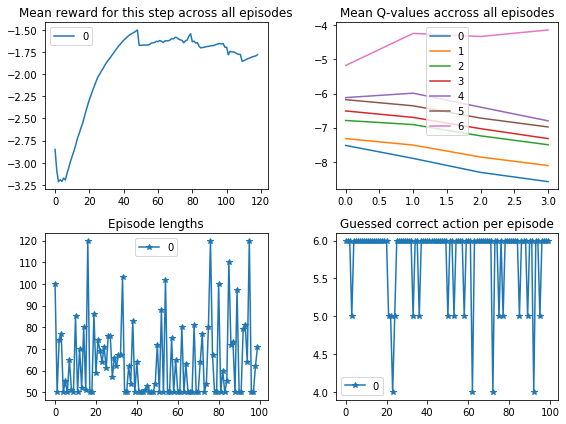

In [19]:
plot_mean_q_values(params={'noise': True, 'surrogate': True})

# Sanity check

In [20]:
max_steps = 120
num_episodes = 100

params = {
    # # Runner parameters
    # 'max_episodes': int(1E6),         # experiment stops after this many episodes
    # 'max_steps': int(1E9),            # experiment stops after this many steps
    # 'multi_runner': False,            # uses multiple runners if True
    # Optimization parameters
    'alpha': 0.5,                       # learning rate of optimizer
    'alpha_decay': 40,
    'alpha_min': 0.001,
    # Exploration parameters
    'epsilon': 1,               # annealing starts at this epsilon
    'epsilon_decay': 20,
    'epsilon_min': 0.01,    
    'gamma': 0.95,                    # discount factor gamma
    'plots': False,
}

print('Accuracy should be higher, timesteps should be lower')

params['surrogate'] = False
params['noise'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 


params['surrogate'] = False
params['noise'] = True
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['surrogate'] = True
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

Accuracy should be higher, timesteps should be lower


100%|██████████| 100/100 [00:00<00:00, 808.61it/s]


100.0 50.0


100%|██████████| 100/100 [00:00<00:00, 549.55it/s]


95.0 64.02


100%|██████████| 100/100 [00:00<00:00, 126.55it/s]

80.0 66.01


# Bayesian optimization

In [21]:
# !pip install bayesian-optimization

In [22]:
max_steps = 120
num_episodes = 100

from bayes_opt import BayesianOptimization

def objective(
        alpha,
        # alpha_decay,
        # alpha_min,
        # epsilon,
        # epsilon_decay,
        # epsilon_min,
        # gamma,
        ):
    # # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # # 'surrogate_lr'    
    # convergence_number_of_consequent_actions
    # intial_q_values: [0, -7]
    params = {
        'alpha': alpha, 
        # 'alpha_decay': alpha_decay,
        # 'alpha_min': alpha_min,
        # 'epsilon': epsilon, 
        # 'epsilon_decay': epsilon_decay,
        # 'epsilon_min': epsilon_min,
        # 'gamma': gamma,
        # 'plots': False,    
    }
    # _, _, _, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)

    return accuracy
    # mean_episode_length = np.mean(episode_lengths)
    # return -mean_episode_length

optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'alpha': (0, 1), 
        # 'alpha_decay': (1, 500),
        # 'alpha_min': (0, 1),
        # 'epsilon': (0, 1), 
        # 'epsilon_decay': (10, 80),
        # 'epsilon_min': (0, 1),
        # 'gamma': (0, 1),
        },
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. 
# The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.
optimizer.maximize(
    init_points=10,
    n_iter=10,
)

best_params = optimizer.max['params']

print(optimizer.max)

|   iter    |  target   |   alpha   |
-------------------------------------


100%|██████████| 100/100 [00:00<00:00, 140.33it/s]


| 1         | 94.0      | 0.417     |


100%|██████████| 100/100 [00:00<00:00, 116.14it/s]


| 2         | 78.0      | 0.7203    |


100%|██████████| 100/100 [00:00<00:00, 189.30it/s]


| 3         | 91.0      | 0.0001144 |


100%|██████████| 100/100 [00:00<00:00, 182.93it/s]


| 4         | 85.0      | 0.3023    |


100%|██████████| 100/100 [00:00<00:00, 189.27it/s]


| 5         | 93.0      | 0.1468    |


100%|██████████| 100/100 [00:00<00:00, 189.76it/s]


| 6         | 91.0      | 0.09234   |


100%|██████████| 100/100 [00:00<00:00, 149.08it/s]


| 7         | 79.0      | 0.1863    |


100%|██████████| 100/100 [00:00<00:00, 151.33it/s]


| 8         | 68.0      | 0.3456    |


100%|██████████| 100/100 [00:00<00:00, 143.42it/s]


| 9         | 85.0      | 0.3968    |


100%|██████████| 100/100 [00:00<00:00, 121.85it/s]


| 10        | 87.0      | 0.5388    |


100%|██████████| 100/100 [00:00<00:00, 179.03it/s]


| 11        | 82.0      | 0.1468    |


100%|██████████| 100/100 [00:00<00:00, 146.96it/s]


| 12        | 96.0      | 0.417     |


100%|██████████| 100/100 [00:00<00:00, 148.48it/s]


| 13        | 95.0      | 0.4171    |


100%|██████████| 100/100 [00:00<00:00, 184.53it/s]


| 14        | 91.0      | 0.09236   |


100%|██████████| 100/100 [00:00<00:00, 139.25it/s]


| 15        | 95.0      | 0.4171    |


100%|██████████| 100/100 [00:00<00:00, 179.09it/s]


| 16        | 92.0      | 0.09231   |


100%|██████████| 100/100 [00:00<00:00, 184.30it/s]


| 17        | 94.0      | 0.1467    |


100%|██████████| 100/100 [00:00<00:00, 137.24it/s]


| 18        | 96.0      | 0.417     |


100%|██████████| 100/100 [00:00<00:00, 180.82it/s]


| 19        | 88.0      | 0.0001514 |


100%|██████████| 100/100 [00:00<00:00, 183.64it/s]

| 20        | 93.0      | 0.09228   |
{'target': 96.0, 'params': {'alpha': 0.4170495462604823}}


# TODO

In [ ]:
import numpy as np
from bayes_opt import BayesianOptimization
from pymoo.optimize import minimize
from pymoo.util import plotting
from pymoo.model.problem import Problem

max_steps = 120
num_episodes = 100

class QLearningProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=np.array([0, 0, 10]), xu=np.array([1, 1, 80]))
    
    def _evaluate(self, X, out, *args, **kwargs):
        alpha, epsilon, epsilon_decay = X

        # Run your Q-learning experiment with given parameters
        params = {'alpha': alpha, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay}
        q_values_all_experiments, _, episode_lengths, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)

        # Maximize accuracy
        out["F"] = [-accuracy, -np.mean(episode_lengths)]

problem = QLearningProblem()

algorithm = minimize(
    algorithm="nsga2",
    problem=problem,
    termination=("n_gen", 20),  # Adjust the number of generations as needed
    save_history=True,
    verbose=True,
)

# Get the best solution from the Pareto front
best_solution = algorithm.result[0]

best_alpha, best_epsilon, best_epsilon_decay = best_solution.X

print(f"Best alpha: {best_alpha}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best epsilon_decay: {best_epsilon_decay}")
print(f"Best accuracy: {-best_solution.F[0]}")
print(f"Best mean_episode_length: {-best_solution.F[1]}")

# You can visualize the Pareto front using pymoo's plotting functions
plotting.plot(obj_space=algorithm.result.F, ideal_point=np.array([0, 0]), title="Pareto Front")


# Profiling

In [24]:
# !pip install line_profiler
%load_ext line_profiler

In [25]:
#402088000.0
max_steps = 120
num_episodes = 2
%lprun -f qLearningExperiment qLearningExperiment(adjust_rewards_surrogate,params={'plots': False})

100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


Timer unit: 1e-09 s

Total time: 0.151271 s
File: /var/folders/hj/_04fr6wx5tncwlntq6ym_zr00000gn/T/ipykernel_5724/1818113075.py
Function: qLearningExperiment at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def qLearningExperiment(difference_fn=None, learner=None, params=default_params()):
     2         1       2000.0   2000.0      0.0      plots = params.get('plots', True)
     3                                           
     4         1          0.0      0.0      0.0      q_values_all_experiments = []
     5         1          0.0      0.0      0.0      rewards_all_experiments = []
     6         1          0.0      0.0      0.0      episode_lengths = []
     7         1          0.0      0.0      0.0      selected_actions = []
     8                                           
     9         3    3286000.0    1e+06      2.2      for i in tqdm(range(num_episodes)):
    10                                       

In [26]:
# 97219000.0/413000.0 = 235
%lprun -f runner runner(adjust_rewards=adjust_rewards_surrogate, params={'plots': False})

Timer unit: 1e-09 s

Total time: 0.117403 s
File: /var/folders/hj/_04fr6wx5tncwlntq6ym_zr00000gn/T/ipykernel_5724/2161407780.py
Function: runner at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def runner(adjust_rewards=None, 
     2                                                      agent=None,
     3                                                      env=None,
     4                                                      params=default_params()):
     5                                           
     6         1      38000.0  38000.0      0.0      agent = agent if agent else UCBQAgent(num_actions=num_states)
     7         1       3000.0   3000.0      0.0      env = env if env else ModifiedRandomEnvironment()
     8                                           
     9         1          0.0      0.0      0.0      episode_rewards = 0
    10         1          0.0      0.0      0.0      rewards = []
    11        

# Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
from IPython import display
import pandas as pd

In [ ]:
max_steps = 120
num_episodes = 20

param_grid = {
    'alpha': [0, 1.0],
    # 'alpha_decay'
    # alpha_min
    'epsilon': [0, 1.0],
    # 'epsilon_decay': [0.1, 1.0],
    # 'gamma'
    'epsilon_decay': [10, 20, 40, 80],
    # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # 'surrogate_lr'
    }

param_grid_out = pd.DataFrame(ParameterGrid(param_grid))

def get_results_from_grid_row(params):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    mean_episode_length = np.mean(episode_lengths)
    print(accuracy, mean_episode_length) 

    return accuracy, mean_episode_length

for i, params in tqdm(param_grid_out.iterrows(), total=param_grid_out.shape[0]):
    accuracy, mean_episode_length = get_results_from_grid_row(params)
    param_grid_out.loc[i, 'accuracy'] = accuracy
    param_grid_out.loc[i, 'mean_episode_length'] = mean_episode_length
    # display.clear_output()

  6%|▋         | 1/16 [00:11<02:47, 11.14s/it]

0.0 121.0


  6%|▋         | 1/16 [00:22<05:40, 22.68s/it]


KeyboardInterrupt: 

In [ ]:
# param_grid_out.iloc[0]['accuracy'] = 1
print(param_grid_out.sort_values(by=['accuracy', 'mean_episode_length'], ascending=False))

    alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
1     0.1      0.1             20      95.0                73.70
7     0.1      1.0             80      90.0                82.70
15    1.0      1.0             80      85.0                91.00
4     0.1      1.0             10      85.0                83.35
10    1.0      0.1             40      85.0                78.55
5     0.1      1.0             20      85.0                75.75
12    1.0      1.0             10      80.0                80.90
6     0.1      1.0             40      75.0                78.45
11    1.0      0.1             80      75.0                78.45
14    1.0      1.0             40      75.0                77.20
8     1.0      0.1             10      75.0                74.95
2     0.1      0.1             40      70.0                87.90
13    1.0      1.0             20      70.0                82.85
3     0.1      0.1             80      65.0                82.65
0     0.1      0.1       

# Q-value of "true" level compared accross different reward techniques

In [ ]:
#TODO:
# What if we reset the state to the original one, every 10 steps, and that would be our episode?
# -> keep the q-values, reset the parameters epsilon, learning rate, etc.

# Epsilon test

In [27]:
np.log10(20+1)

1.3222192947339193

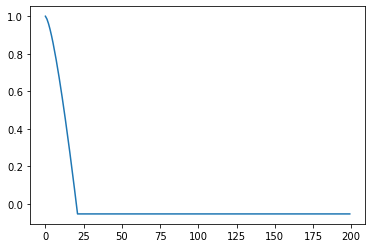

In [23]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.epsilon)
    agent.choose_action(0)

plt.plot(epsilons)

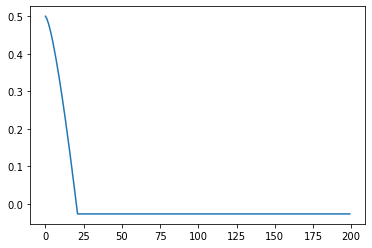

In [28]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.alpha)
    agent.choose_action(0)

plt.plot(epsilons)

# Surrogate rewards without adding noise

In [ ]:
from modified_pendulum_processor_noiseless import ModifiedPendulumProcessorNoiseless

100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


Mean episode length: 61.0
Accuracy: 100.0
[[0.8 0.  0.  0.  0.  0.  0.2]
 [0.  0.8 0.  0.  0.  0.2 0. ]
 [0.  0.  0.8 0.  0.2 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.8 0.  0. ]
 [0.  0.2 0.  0.  0.  0.8 0. ]
 [0.2 0.  0.  0.  0.  0.  0.8]]
{(0, 3): [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3], (0, 0): [-6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6, -6], (0, 1): [-5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5, -5], (0, 2): [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4], (0, 4): [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], (0, 5): [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

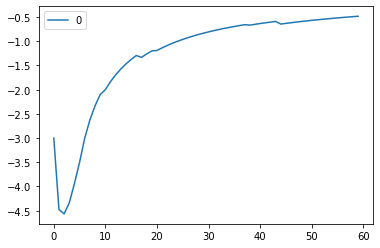

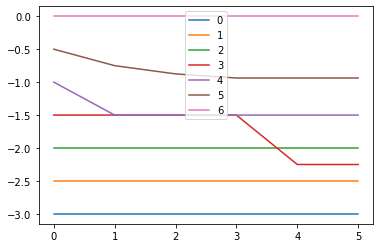

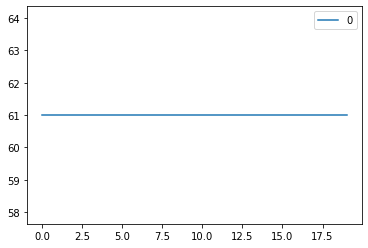

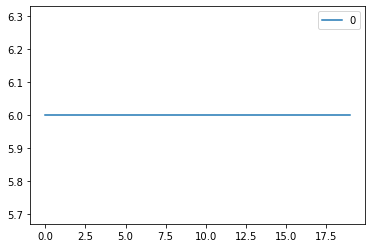

In [ ]:
post_processor_surrogate = ModifiedPendulumProcessorNoiseless()

def adjust_rewards_surrogate(reward, state, action):    
    observation, reward, done, info = post_processor_surrogate.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards_surrogate)

print(post_processor_surrogate.cmat)
print(post_processor_surrogate.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor_surrogate.C, decimals=4))